In [1]:
import sys
sys.path.insert(0, '../src')
import harmoutil

import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit

from keras.models import Model
from keras.layers import Input, Dense, GRU, concatenate

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import load_model

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Load data
raw_data = harmoutil.load_pickled_data("../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections
print("---Raw data---")
print("Number of sections: {}".format(len(raw_data)))
print("Sample section: {}\n".format(raw_data[0]))
augmented_data = harmoutil.transpose_and_augment_data(raw_data)
print("---Transpose and augment data---")
print("Number of sections after data augmentation: {}".format(len(augmented_data)))
print("Sample section: {}\n".format(augmented_data[0]))
data = [harmoutil.to_sevenths(section) for section in augmented_data]
print("---Truncate chords to sevenths---")
print("Number of sections: {}".format(len(data)))
print("Sample section: {}\n".format(data[0]))
data = [harmoutil.melody_to_octave_range(section) for section in data]
print("---Convert melody to integers---")
print("Number of sections: {}".format(len(data)))
print("Sample section: {}\n".format(data[0]))

---Raw data---
Number of sections: 2408
Sample section: [('Bb6', [[58.0], [58.0]]), ('G7', [[-1.0], [-1.0]]), ('C-7', [[-1.0], [-1.0]]), ('F7', [[-1.0], [-1.0]]), ('Bb', [[-1.0], [-1.0]]), ('G-7', [[50.0], [57.0, 60.0]]), ('C-7', [[58.0, 55.0], [58.0]]), ('F7', [[61.0], [60.0, 58.0]]), ('F-7', [[60.0], [58.0]]), ('Bb7', [[56.0, 60.0], [59.0, 57.0]]), ('Eb7', [[58.0, 54.0], [55.0, 58.0]]), ('Ab7', [[61.0, 56.0], [61.0, 62.0]]), ('D-7', [[58.0, 60.0], [55.0, 58.0]]), ('G7', [[58.0], [-1.0]]), ('C-7', [[-1.0], [-1.0]]), ('F7', [[-1.0], [-1.0]])]

---Transpose and augment data---
Number of sections after data augmentation: 28884
Sample section: [('E6', [[52.0], [52.0]]), ('Db7', [[-1.0], [-1.0]]), ('Gb-7', [[-1.0], [-1.0]]), ('B7', [[-1.0], [-1.0]]), ('E', [[-1.0], [-1.0]]), ('Db-7', [[44.0], [51.0, 54.0]]), ('Gb-7', [[52.0, 49.0], [52.0]]), ('B7', [[55.0], [54.0, 52.0]]), ('B-7', [[54.0], [52.0]]), ('E7', [[50.0, 54.0], [53.0, 51.0]]), ('A7', [[52.0, 48.0], [49.0, 52.0]]), ('D7', [[55.0, 

In [3]:
# Create individual chord and melody element lists 
def get_notes_by_chord(beats):
    return [note for beat in beats for note in beat]

def get_chords_by_section(section):
    return [chord_info[0] for chord_info in section]

def check_if_augmented_major(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "+j7" in ch:
            return True
    return False


# Remove sections that involve augmented major chords (since not enough data to even allow StratifiedShuffleSplit)
data = [section for section in data if not check_if_augmented_major(section)]
print("---Remove sections with augmented major chord---")
print("Number of sections: {}\n".format(len(data)))

chords_by_sections = [get_chords_by_section(section) for section in data]
chords = [chord_info[0] for section in data for chord_info in section]
notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in data for chord_info in section]
notes = [note for chord_notes in notes_by_chords for note in chord_notes]
# print(sum([len(section) for section in chords_by_sections]))
print("Number of sections: {} | Sample section chords: {}".format(len(chords_by_sections), chords_by_sections[0]))
print("Number of chords: {} | Sample chord: {}".format(len(chords), chords[0]))
print("Number of melodies {} | Sample melody: {}".format(len(notes_by_chords), notes_by_chords[0]))
print("Number of melody notes in the data: {} | Sample melody note: {}".format(len(notes), notes[0]))

---Remove sections with augmented major chord---
Number of sections: 28836

Number of sections: 28836 | Sample section chords: ['E6', 'Db7', 'Gb-7', 'B7', 'E', 'Db-7', 'Gb-7', 'B7', 'B-7', 'E7', 'A7', 'D7', 'Ab-7', 'Db7', 'Gb-7', 'B7']
Number of chords: 333480 | Sample chord: E6
Number of melodies 333480 | Sample melody: [4, 4]
Number of melody notes in the data: 2195328 | Sample melody note: 4


In [4]:
# Create categorical data mappings

# Note to integer index
note_to_int = dict([(c, i) for i, c in enumerate(sorted(list(set(notes)))[1:])])
note_to_int[-1] = len(note_to_int)
note_to_int['<pad>'] = len(note_to_int)
print("Melody note to integer mapping:\n {}\n".format(note_to_int))

# Integer to note
int_to_note = dict([(k, v) for v, k in note_to_int.items()])
print("Integer to melody note mapping:\n {}\n".format(int_to_note))

# Chord to integer index
chord_to_int = dict([(c, i) for i, c in enumerate(sorted(list(set(chords))))])
chord_to_int['<bos>'] = len(chord_to_int)
print("Chord label to integer mapping:\n {}\n".format(chord_to_int))


# Integer to chord index
int_to_chord = dict([(k, v) for v, k in chord_to_int.items()])
print("Integer to chord label mapping:\n {}\n".format(int_to_chord))

Melody note to integer mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, '<pad>': 13, -1: 12}

Integer to melody note mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: -1, 13: '<pad>'}

Chord label to integer mapping:
 {'Gsus7': 179, 'Co7': 72, 'Gb-6': 163, 'Em7b5': 130, 'NC': 180, 'Ab-6': 13, 'Dbo': 95, 'Abo7': 21, 'Bo': 56, 'A': 0, 'Do': 101, 'Bbm7b5': 49, 'Gbo7': 171, 'D-7': 80, 'Go': 176, 'Eb+7': 116, 'Db+7': 86, 'Bbj7': 48, 'Gb-': 162, 'Gb-7': 164, 'B-7': 35, 'D7': 83, 'C': 60, 'D+7': 77, 'Fo7': 147, 'Do7': 102, 'Eo': 131, 'Ebsus': 127, 'Bbsus7': 53, 'F-': 138, 'A+7': 2, 'Gbsus': 172, 'Fo': 146, 'Bb': 39, 'C-': 63, 'Esus7': 134, 'D': 75, 'Bb+': 40, 'C7': 68, 'Db-': 87, 'Dbj7': 93, 'Gb+7': 161, 'Gb6': 166, 'Ab-7': 14, 'Bb6': 46, 'Ao': 26, 'Go7': 177, 'Aj7': 24, 'E+7': 107, 'E-': 108, 'A7': 8, 'Gbm7b5': 169, 'G': 150, 'E7': 113, 'C+7': 62, 'D6': 82, 'E': 105, 'Gj7': 174, 'E-7': 110, 'F-6': 139, 'Db-6': 88,

In [5]:
# Define numerical variables

n_samples = len(chords)
n_notes = len(note_to_int)
n_chords = len(chord_to_int)
n_pitches = 12
max_melody_len = max([len(mel_seq) for mel_seq in notes_by_chords])
chord_context_len = 7

print("Total number of samples: {}".format(n_samples))
print("Number of distinct melody notes: {}".format(n_notes))
print("Number of distinct chord labels: {}".format(n_chords))
print("Number of distinct chord pitches: {}".format(n_pitches))
print("Maximum melody sequence length: {}".format(max_melody_len))
print("Fixed context chord sequence length: {}".format(7))

Total number of samples: 333480
Number of distinct melody notes: 14
Number of distinct chord labels: 182
Number of distinct chord pitches: 12
Maximum melody sequence length: 135
Fixed context chord sequence length: 7


In [6]:
# Prepare tensor data

def pad_melody(melody, max_len):
    return melody + (max_len-len(melody))*['<pad>']

def build_input_chord_sequences(chord_seq, context_len):
    padded_sequence = context_len*['<bos>'] + chord_seq
    formatted_sequences = [padded_sequence[i:i+context_len+1] for i in range(len(chord_seq))]
    return formatted_sequences

# Melody
input_melody_data = [pad_melody(melody, max_melody_len) for melody in notes_by_chords]
print("Sample input melody sequence: {}\n".format(input_melody_data[5]))


# Chords
formatted_chords_data = []
for section_chords in chords_by_sections:
    formatted_chords_data += build_input_chord_sequences(section_chords, chord_context_len)

input_chords_data = [ch[:-1] for ch in formatted_chords_data]
target_chords_data = [ch[-1] for ch in formatted_chords_data]
print("Sample input chord sequence: {}\n".format(input_chords_data[5]))
print("Sample target chord: {}\n".format(target_chords_data[5]))

print("Input melody: {}, Input chords: {}, Target chords: {}".format(len(input_melody_data), len(input_chords_data), len(target_chords_data)))

Sample input melody sequence: [8, 3, 6, '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

In [7]:
# Build tensors

X_melody = np.zeros((n_samples, max_melody_len, n_notes), dtype='float32')
X_chords = np.zeros((n_samples, chord_context_len, n_pitches), dtype='float32')
Y = np.zeros((n_samples, n_pitches), dtype='float32')
Y_labels = np.zeros((n_samples, n_chords), dtype='float32')

for i, (input_mel, input_ch, target_ch) in enumerate(zip(input_melody_data, input_chords_data, target_chords_data)):
    
    Y_labels[i, chord_to_int[target_ch]] = 1 # tensor of chords one-hot vectors used for dataset splitting
    
    target_chord_pitches = [0]*12 if target_ch == '<bos>' else harmoutil.chord_to_notes(target_ch)
    for j, pitch_presence in enumerate(target_chord_pitches):
        Y[i, j] = pitch_presence

    for j, chord in enumerate(input_ch):
        input_chord_pitches = [0]*12 if chord == '<bos>' else harmoutil.chord_to_notes(chord)
        for k, pitch_presence in enumerate(input_chord_pitches):
            X_chords[i, j, k] = pitch_presence


In [8]:
# Split dataset into 80%-10%-10% train-valid-test

seed = 0

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in sss.split(X_chords, Y_labels):
    X_melody_train, X_melody_aux = X_melody[train_index], X_melody[aux_index]
    X_chords_train, X_chords_aux = X_chords[train_index], X_chords[aux_index]
    Y_train, Y_aux = Y[train_index], Y[aux_index]
    Y_labels_train, Y_labels_aux = Y_labels[train_index], Y_labels[aux_index]
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)

for valid_index, test_index in sss.split(X_chords_aux, Y_labels_aux):
    X_melody_valid, X_melody_test = X_melody[valid_index], X_melody[test_index]
    X_chords_valid, X_chords_test = X_chords[valid_index], X_chords[test_index]
    Y_valid, Y_test = Y[valid_index], Y[test_index]
    Y_labels_valid, Y_labels_test = Y_labels[valid_index], Y_labels[test_index]

In [10]:
# Define neural net architecture

latent_dim = 128

melody_input = Input(shape=(max_melody_len, n_notes))
melody_gru1 = GRU(latent_dim, return_sequences=True)(melody_input)
melody_gru2 = GRU(latent_dim)(melody_gru1)

chords_input = Input(shape=(chord_context_len, n_pitches))
chords_gru = GRU(latent_dim)(chords_input)

concat = concatenate([melody_gru2, chords_gru])

chord_dense = Dense(n_pitches, activation='sigmoid')(concat)

model = Model([melody_input, chords_input], chord_dense)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
# SVG(model_to_dot(model).create(prog='dot', format='svg'))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 135, 14)       0                                            
____________________________________________________________________________________________________
gru_4 (GRU)                      (None, 135, 128)      54912       input_3[0][0]                    
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 7, 12)         0                                            
____________________________________________________________________________________________________
gru_5 (GRU)                      (None, 128)           98688       gru_4[0][0]                      
___________________________________________________________________________________________

In [11]:
# Introduce Early-Stopping and Save-Best-Performance callbacks
filepath = "../models/pitch-Mel2-Cho1-FC1_150ep.h5"
bp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [12]:
# Train model
batch_size = 256
epochs = 150

history = model.fit([X_melody_train, X_chords_train], Y_train, epochs=epochs, validation_data=([X_melody_valid, X_chords_valid], Y_valid,), batch_size=batch_size, callbacks=[bp])

Train on 266784 samples, validate on 33348 samples
Epoch 1/150
266784/266784 [==============================] - 324s - loss: 0.5590 - acc: 0.7221 - val_loss: 0.5229 - val_acc: 0.7511
Epoch 2/150
266784/266784 [==============================] - 322s - loss: 0.5069 - acc: 0.7617 - val_loss: 0.4872 - val_acc: 0.7747
Epoch 3/150
266784/266784 [==============================] - 322s - loss: 0.4790 - acc: 0.7787 - val_loss: 0.4690 - val_acc: 0.7860
Epoch 4/150
266784/266784 [==============================] - 322s - loss: 0.4600 - acc: 0.7896 - val_loss: 0.4548 - val_acc: 0.7933
Epoch 5/150
266784/266784 [==============================] - 322s - loss: 0.4452 - acc: 0.7980 - val_loss: 0.4464 - val_acc: 0.7983
Epoch 6/150
266784/266784 [==============================] - 323s - loss: 0.4332 - acc: 0.8045 - val_loss: 0.4386 - val_acc: 0.8036
Epoch 7/150
266784/266784 [==============================] - 324s - loss: 0.4229 - acc: 0.8105 - val_loss: 0.4311 - val_acc: 0.8075
Epoch 8/150
266784/266784

266784/266784 [==============================] - 364s - loss: 0.3279 - acc: 0.8583 - val_loss: 0.3878 - val_acc: 0.8355
Epoch 55/150
266784/266784 [==============================] - 361s - loss: 0.3277 - acc: 0.8585 - val_loss: 0.3888 - val_acc: 0.8356
Epoch 56/150
266784/266784 [==============================] - 369s - loss: 0.3270 - acc: 0.8589 - val_loss: 0.3885 - val_acc: 0.8360
Epoch 57/150
266784/266784 [==============================] - 369s - loss: 0.3268 - acc: 0.8587 - val_loss: 0.3877 - val_acc: 0.8356
Epoch 58/150
266784/266784 [==============================] - 365s - loss: 0.3266 - acc: 0.8590 - val_loss: 0.3877 - val_acc: 0.8368
Epoch 59/150
266784/266784 [==============================] - 368s - loss: 0.3261 - acc: 0.8592 - val_loss: 0.3867 - val_acc: 0.8376
Epoch 60/150
266784/266784 [==============================] - 369s - loss: 0.3258 - acc: 0.8594 - val_loss: 0.3891 - val_acc: 0.8360
Epoch 61/150
266784/266784 [==============================] - 362s - loss: 0.3252 

266784/266784 [==============================] - 369s - loss: 0.3145 - acc: 0.8643 - val_loss: 0.3846 - val_acc: 0.8397
Epoch 116/150
266784/266784 [==============================] - 363s - loss: 0.3144 - acc: 0.8644 - val_loss: 0.3832 - val_acc: 0.8400
Epoch 117/150
266784/266784 [==============================] - 363s - loss: 0.3142 - acc: 0.8643 - val_loss: 0.3823 - val_acc: 0.8406
Epoch 118/150
266784/266784 [==============================] - 365s - loss: 0.3141 - acc: 0.8644 - val_loss: 0.3827 - val_acc: 0.8404
Epoch 119/150
266784/266784 [==============================] - 367s - loss: 0.3140 - acc: 0.8644 - val_loss: 0.3829 - val_acc: 0.8408
Epoch 120/150
266784/266784 [==============================] - 365s - loss: 0.3136 - acc: 0.8648 - val_loss: 0.3814 - val_acc: 0.8410
Epoch 121/150
266784/266784 [==============================] - 361s - loss: 0.3138 - acc: 0.8645 - val_loss: 0.3821 - val_acc: 0.8405
Epoch 122/150
266784/266784 [==============================] - 363s - loss: 

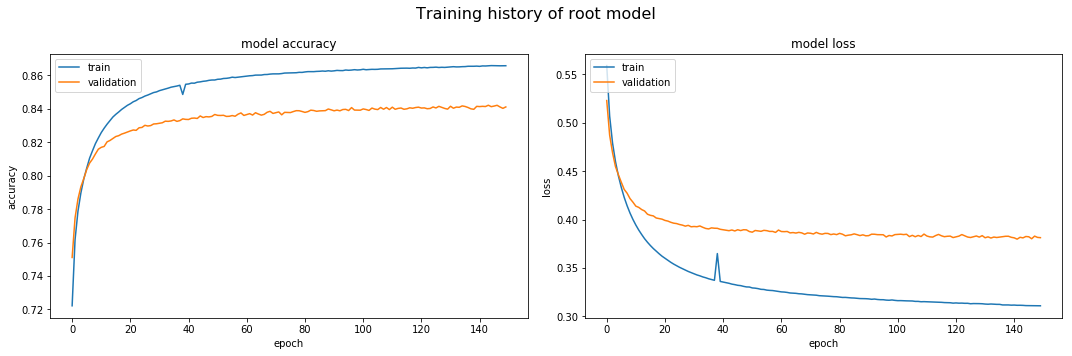

In [13]:
# Visualize model learning
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.suptitle("Training history of root model", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [14]:
### Load best performance model ###
model = load_model("../models/pitch-Mel2-Cho1-FC1_150ep.h5")

In [15]:
# Evaluate predictions in terms of labels

# Predict chords from each test sample melody
Y_pred = model.predict([X_melody_test, X_chords_test])

# Compute accuracy and kappa score
print("Categorical accuracy of combined chord prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(Y_test, Y_pred)))
print("Kappa score of combined chord prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(Y_test, Y_pred)))

Categorical accuracy of combined chord prediction: 0.8384
TP: 86538 TN: 248958 FP: 21092 FN: 43588
Kappa score of combined chord prediction: 0.6144
